# LAB 3

## Implementation of a Harris corner detctor, as was coverd in the lectures in the slides. 

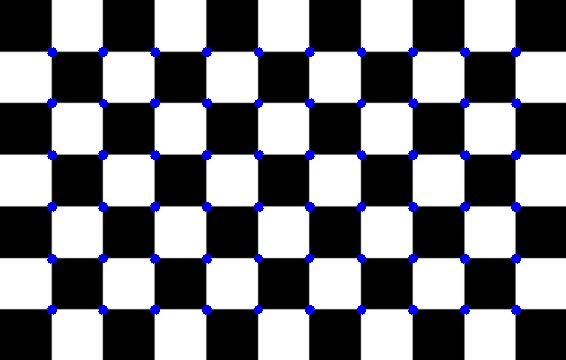

In [2]:
import cv2 as cv
import numpy as np
from IPython.display import Image

# Load image
img = cv.imread('checkerBoard.jpg')

block_size = 2
kernel_size =  3
k = 0.04

# Convert image to grayscale
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Calculate image derivatives Ix and Iy
Ix = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=kernel_size)
Iy = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=kernel_size)
# Calculate measures IxIx, IyIy and IxIy
IxIx = Ix ** 2
IyIy = Iy ** 2
IxIy = Ix * Iy
# Calculate structure matrix components as weighted sum of nearby measures
Sxx = cv.boxFilter(IxIx, -1, (block_size, block_size))
Syy = cv.boxFilter(IyIy, -1, (block_size, block_size))
Sxy = cv.boxFilter(IxIy, -1, (block_size, block_size))
# Calculate Harris "cornerness" as estimate of 2nd eigenvalue: det(S)/tr(S)
detS = Sxx * Syy - Sxy ** 2
trS = Sxx + Syy
R = detS - k * trS ** 2

# Run non-max suppression on response map
corners = cv.dilate(R, None)
threshold = 0.01 * corners.max()
corners[R < threshold] = 0

# Plot corner points on image
for y in range(corners.shape[0]):
    for x in range(corners.shape[1]):
        if corners[y, x] != 0:
            cv.circle(img, (x, y), 3, (255, 0, 0), -1)
            
        
output_filename = 'output.jpg'
cv.imwrite(output_filename, img)

Image(output_filename)


## Patch Matching

### To use corners for aligning two (or more) images, we have to match up the corner detections with their appropriate counterpart in the other image. Write code to match corners from one image to another using small descriptors (image patches) around the image corner pixel. Find their best match with descriptors between images. Make sure you eliminate non-symmetric matches by considering that the best match for a descriptor in image A is reciprocated when that feature in B is matched to descriptors in A.

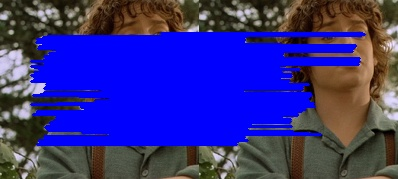

In [24]:
import cv2 as cv
import numpy as np
from IPython.display import Image

# Load two images
img1 = cv.imread('patchMatching1.png')
img2 = cv.imread('patchMatching1.png')

# Calculate the aspect ratios of the two images
aspect_ratio1 = img1.shape[1] / img1.shape[0]
aspect_ratio2 = img2.shape[1] / img2.shape[0]

# Calculate the aspect ratio of finalImage
finalImage_aspect_ratio = aspect_ratio1 + aspect_ratio2

# Calculate the new heights of the images to maintain their aspect ratios
img1_height = int(img1.shape[1] / finalImage_aspect_ratio)
img2_height = int(img2.shape[1] / finalImage_aspect_ratio)

# Resize the images to their new heights
img1_resized = cv.resize(img1, (int(img1_height * aspect_ratio1), img1_height))
img2_resized = cv.resize(img2, (int(img2_height * aspect_ratio2), img2_height))

# Convert images to grayscale
gray1 = cv.cvtColor(img1_resized, cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(img2_resized, cv.COLOR_BGR2GRAY)

# Initialize the ORB feature detector
orb = cv.ORB_create()

# Detect keypoints and compute descriptors for both images
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

# Initialize a BFMatcher with default parameters for ORB
bf = cv.BFMatcher(cv.NORM_HAMMING)

# Match the descriptors and find the two nearest neighbors for each descriptor
matches = bf.knnMatch(des1, des2, k=2)

# Define the ratio test threshold
ratio_thresh = 0.75

# Apply the ratio test and store the good matches
good_matches = []
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

# Store the matched keypoints
matched_corners = [(kp1[m.queryIdx].pt, kp2[m.trainIdx].pt) for m in good_matches]

# Create a new empty image with the same height as the input images and double the width
finalImage = np.zeros((img1_height, int(img1_height * finalImage_aspect_ratio), 3), dtype=np.uint8)

# Copy the input images into the result image side by side
finalImage[:img1_height, :img1_resized.shape[1]] = img1_resized
img2_resized = cv.resize(img2_resized, (199, 179))
finalImage[:img2_height, img1_resized.shape[1]:] = img2_resized

# Draw lines between the matched corners
for match in matched_corners:
    (x1, y1), (x2, y2) = match
    cv.line(finalImage, (int(x1), int(y1)), (int(x2) + img1_resized.shape[1], int(y2)), (255, 0, 0), 2)

output_filename = 'PatchMatchingResult.jpg'
cv.imwrite(output_filename, finalImage)
Image(output_filename)


## Stereo Vision
### In this lab, you will implement a simple stereo algorithm using Python. You may use google Colab/Jupyter Notebooks as well, similar to previous assignments.

### For the exercise, you will implement a simple window-based stereo matching algorithm as described in the slides during the course lectures. You may compare patches using a sum of squared-error or other similar metric.

### For a dataset, it suggest that you find data from the Middlebury archive. Here is one example Middlebury dataset: 2014 Stereo datasets with ground truth . These datasets contain left and right pairs, but also ground truth images for the calculated disparity maps. Using the window matching approach as described in the slides, calculate an estimated disparity map for one of the example image pairs found in this dataset. Compare the disparity map you calculate to the ground truth disparity map by plotting the difference map.

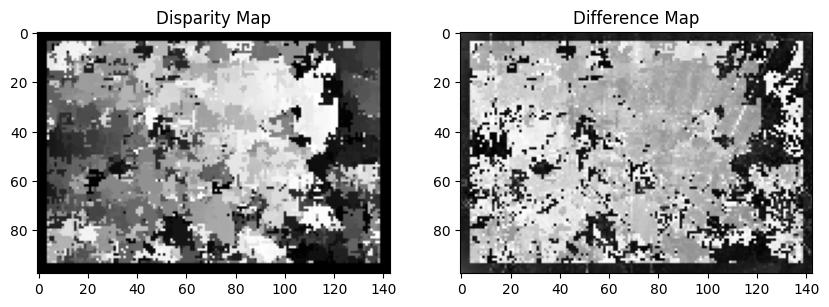

In [27]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load left and right images from Middlebury dataset
left = cv2.imread('im0.png')
right = cv2.imread('im1.png')

# Convert images to grayscale
gray_left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

# Define window size and disparity range
window_size = 9
disparity_range = 128

# Initialize disparity map to zeros
disparity_map = np.zeros_like(gray_left)

# Iterate over each pixel in the left image
for y in range(window_size // 2, gray_left.shape[0] - window_size // 2):
    for x in range(window_size // 2, gray_left.shape[1] - window_size // 2):
        
        # Define left patch
        left_patch = gray_left[y - window_size // 2:y + window_size // 2 + 1, x - window_size // 2:x + window_size // 2 + 1]
        
        # Initialize minimum SSD and corresponding disparity
        min_ssd = np.inf
        min_disp = 0
        
        # Iterate over disparity range
        for d in range(disparity_range):
            
            # Define right patch
            right_patch = gray_right[y - window_size // 2:y + window_size // 2 + 1, x - window_size // 2 - d:x + window_size // 2 + 1 - d]
            
            # Check if right patch is within image bounds
            if right_patch.shape[1] == window_size:
                # Calculate SSD
                ssd = np.sum((left_patch - right_patch)**2)
            else:
                # Set SSD to large value if patch is out of bounds
                ssd = np.inf
            
            # Update minimum SSD and corresponding disparity if necessary
            if ssd < min_ssd:
                min_ssd = ssd
                min_disp = d
        
        # Set disparity value for pixel
        disparity_map[y, x] = min_disp

# Load ground truth disparity map
ground_truth = cv2.imread('./Adirondack-perfect/disp0-sd.pfm', cv2.IMREAD_GRAYSCALE)

# Check if loading succeeded
if ground_truth is None:
    print('Error: failed to load ground truth disparity map')
else:
    # Resize ground truth disparity map to match dimensions of disparity map
    ground_truth_resized = cv2.resize(ground_truth, (disparity_map.shape[1], disparity_map.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Calculate difference map
    diff_map = np.abs(ground_truth_resized - disparity_map)

    # Plot disparity map and difference map
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(disparity_map, cmap='gray')
    plt.title('Disparity Map')
    plt.subplot(1, 2, 2)
    plt.imshow(diff_map, cmap='gray')
    plt.title('Difference Map')
    plt.show()
